<a href="https://colab.research.google.com/github/Salomey2000/TUTORIALS/blob/main/salomey_frimpong_INN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**PROBLEM 4**

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip

In [24]:
IMG_LEN = 28
IMG_SIZE = IMG_LEN**2

In [25]:
class QuadraticLoss(object):
    @staticmethod
    def loss(a, y):
        return 0.5*np.dot(a-y, a-y)
    @staticmethod
    def loss_derivative(a, y):
        return a-y

In [26]:
class CrossEntropyLoss(object):
    @staticmethod
    def loss(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    @staticmethod
    def loss_derivative(a, y):
        return (a-y)/(a*(1.0-a))

In [27]:
class Network(object):
    def __init__(self, n, *, loss=QuadraticLoss, init='standard'):
        # Initialize the weights randomly
        if init == 'standard':
            self.W = np.random.randn(n, IMG_SIZE)
            self.V = np.random.randn(10, n)
        elif init == 'normalized':
            self.W = np.random.randn(n, IMG_SIZE) / np.sqrt(IMG_SIZE)
            self.V = np.random.randn(10, n) / np.sqrt(n)

        self.b = np.random.randn(n)
        self.bprime = np.random.randn(10)
        self.loss = loss

    def feedforward(self, x):
        # Return the output of a feedforward pass
        a = sigmoid(np.dot(self.W, x)+self.b)
        return sigmoid(np.dot(self.V, a)+self.bprime)

    def evaluate(self, data, *, lmbda=0):
        """ Return (cost, accuracy) on the data"""
        correct_samples = 0
        total_cost = 0
        n_samples = len(data)

        for x, ylabel in data:
            y = self.feedforward(x)
            prediction = np.argmax(y)
            if prediction == ylabel:
                correct_samples += 1

            total_cost += self.loss.loss(y, Network.vec_output[ylabel])

        average_cost = total_cost / n_samples
        average_cost += 0.5*lmbda*(
            np.linalg.norm(self.W)**2 + np.linalg.norm(self.V)**2)

        return average_cost, correct_samples / n_samples


    def update_mini_batch(self, mini_batch, eta, lmbda):
        # Run backprop and update weights on the minibatch
        k = len(mini_batch)
        delta_W = np.zeros(self.W.shape)
        delta_b = np.zeros(self.b.shape)
        delta_V = np.zeros(self.V.shape)
        delta_bprime = np.zeros(self.bprime.shape)

        for x, y in mini_batch:
            nabla_W, nabla_b, nabla_V, \
                nabla_bprime = self.backprop(x, y)
            delta_W += nabla_W
            delta_b += nabla_b
            delta_V += nabla_V
            delta_bprime += nabla_bprime

        self.W -= eta*(lmbda*self.W + 1/k * delta_W)
        self.b -= eta/k * delta_b
        self.V -= eta*(lmbda*self.V + 1/k * delta_V)
        self.bprime -= eta/k * delta_bprime

    def SGD_early_stopping(self, training_data, *, no_epoch, mini_batch_size,
            eta, lmbda=0, test_data=[]):
        # Run SGD with those parameters
        # Return a list of results for every epoch
        # For each epoch, append pair (self.evaluate(training_data),
        #        self.evaluate(test_data))
        res1 = [0]
        my_stop=list(range(5))
        my_epochs=0
        while max(my_stop)-min(my_stop)>no_epoch:
            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j:j+mini_batch_size]
                self.update_mini_batch(mini_batch, eta, lmbda)

            res1.append((self.evaluate(training_data),
                       self.evaluate(test_data)))

            my_stop=my_stop[1::]
            my_epochs+=1
            my_stop.append(res1[my_epochs][1][1])


            print('Epoch '+str(my_epochs-1)+' finished')

        return res1[1::]


    def SGD(self, training_data,*, epochs, mini_batch_size,
            eta, lmbda=0, test_data=[]):
        # Run SGD with those parameters
        # Return a list of results for every epoch
        # For each epoch, append pair (self.evaluate(training_data),
        #        self.evaluate(test_data))
        res = []

        for i in range(epochs):
            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j:j+mini_batch_size]
                self.update_mini_batch(mini_batch, eta,lmbda)

            res.append((self.evaluate(training_data),
                       self.evaluate(test_data)))

            print('Epoch '+str(i)+' finished')

        return res


    def SGD_var_learning_rate(self, training_data, no_epoch, mini_batch_size, eta, lmbda=1, test_data=[]):
        res2 = []

        learn_rates= [eta/ 10**(i) for i in range(3)]


        for lr in learn_rates:

            part_res= self.SGD_early_stopping(training_data= train_data, no_epoch= no_epoch,
                                   mini_batch_size= mini_batch_size, eta= lr,
                                   lmbda= lmbda, test_data= test_data)

        # Append the results to the overall list of results
            for r in part_res:
                res2.append(r)

    # Return the complete list of results
        return res2






    def backprop(self, x, ylabel):
        # feedforward
        z1 = np.dot(self.W, x)+self.b
        a1 = sigmoid(z1)
        z2 = np.dot(self.V, a1)+self.bprime
        a2 = sigmoid(z2)

        # backward
        delta_2 = self.loss.loss_derivative(a2, Network.vec_output[ylabel]) * sigmoid_prime(z2)
        nabla_bprime = delta_2
        nabla_V = np.outer(delta_2, a1)

        delta_1 = np.dot(self.V.transpose(), delta_2) * sigmoid_prime(z1)
        nabla_b = delta_1
        nabla_W = np.outer(delta_1, x)

        return nabla_W, nabla_b, nabla_V, nabla_bprime

    vec_output = []
    for ylabel in range(10):
        V = np.zeros(10)
        V[ylabel] = 1
        vec_output.append(V)

In [33]:
def sigmoid(z):
    return 1 / (1.0+np.exp(-z))
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [38]:

def load_data():
    try:
        f = gzip.open('mnist.pkl.gz', 'rb')
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
        f.close()
        return training_data, validation_data, test_data
    except Exception as e:
        print(f"An error occurred: {e}")


In [39]:
TRAIN, VALIDATION, TEST = load_data()

In [40]:
def zip_data(D):
    return list(zip(D[0], D[1]))


In [41]:
train_data = zip_data(TRAIN)
validation_data = zip_data(VALIDATION)
test_data = zip_data(TEST)

In [42]:
def plot_results(res):
    X = list(range(len(res)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    train_acc = [x[0][1] for x in res]
    test_acc = [x[1][1] for x in res]
    ax1.plot(X, train_acc, label='train')
    ax1.plot(X, test_acc, label='test')
    ax1.legend()

    train_cost = [x[0][0] for x in res]
    test_cost = [x[1][0] for x in res]
    ax2.plot(X, train_cost, label='train')
    ax2.plot(X, test_cost, label='test')
    ax2.legend()

    print(np.max([x[1][1] for x in res]))

###**Original training**

In [59]:
NET = Network(30)
results = NET.SGD(train_data,
                  epochs=30,
                  mini_batch_size=10,
                  eta=3.0,
                  test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9503


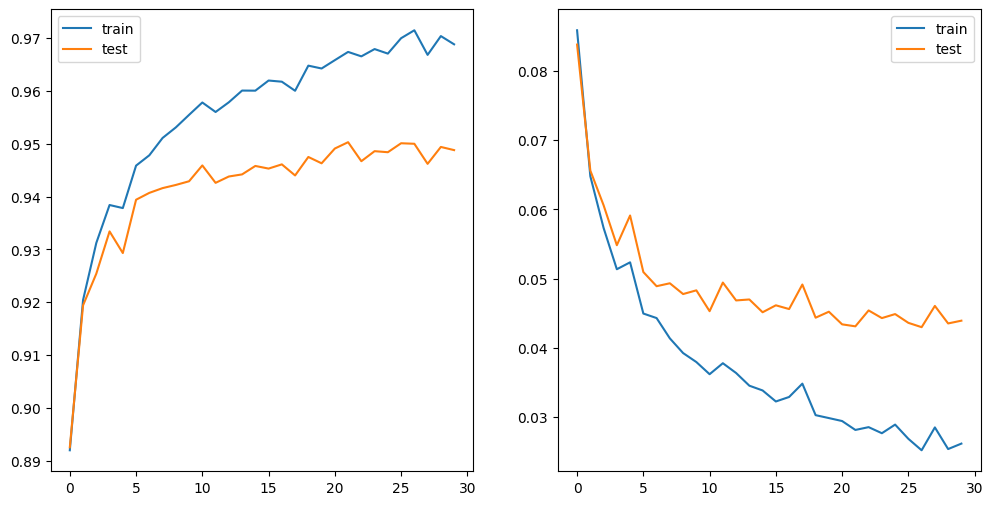

In [61]:
plot_results(results)

In [46]:
def plot_digit(img):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    plt.imshow(1-img, cmap='gray')

In [48]:
def shifted_image(img, shift_r, shift_c):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    res = np.zeros_like(img)
    for row in range(IMG_LEN):
        new_row = row + shift_r
        if new_row >= 0 and new_row < IMG_LEN:
            for col in range(IMG_LEN):
                new_col = col + shift_c
                if new_col >= 0 and new_col < IMG_LEN:
                  res[new_row, new_col] = img[row, col]
    return np.reshape(res, (IMG_SIZE,))

(None, 5)

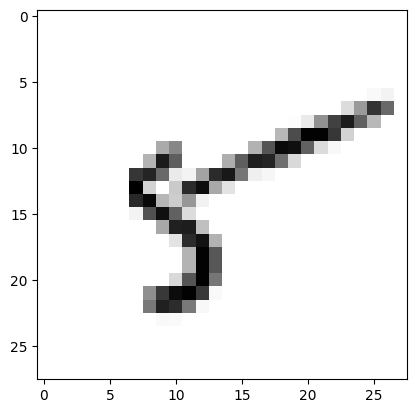

In [50]:
plot_digit(train_data[30][0]), train_data[30][1]

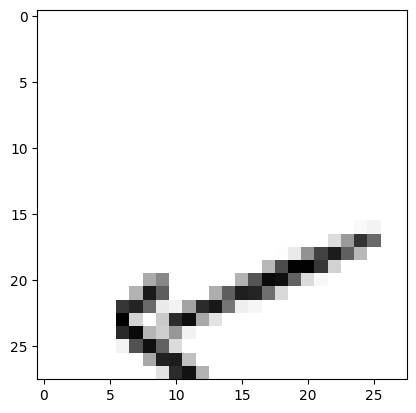

In [51]:
plot_digit(shifted_image(train_data[30][0], 10, -1))

In [52]:
expanded_train_data = []
for x, ylabel in train_data:
    expanded_train_data.append((x, ylabel))
    for r_shift, c_shift in [(+1, 0), (-1, 0), (0, +1), (0, -1)]:
        expanded_train_data.append((
            shifted_image(x, r_shift, c_shift),
            ylabel
        ))

In [53]:
len(expanded_train_data)

250000

In [62]:
NET5 = Network(30, loss=CrossEntropyLoss, init='normalized')
results5 = NET5.SGD(expanded_train_data,
                    epochs=30,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9676


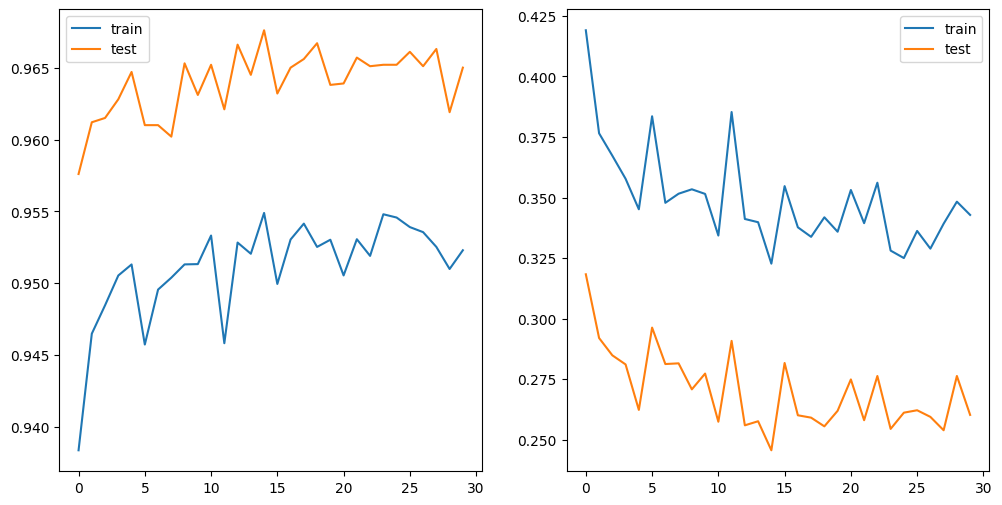

In [63]:
plot_results(results5)

##  **Early stopping**

In [64]:
NET7 = Network(100, loss=CrossEntropyLoss, init='normalized')
results7 = NET7.SGD_early_stopping(train_data,
                    no_epoch=1e-1, #set the threshold no_epoch as 1/10
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9708


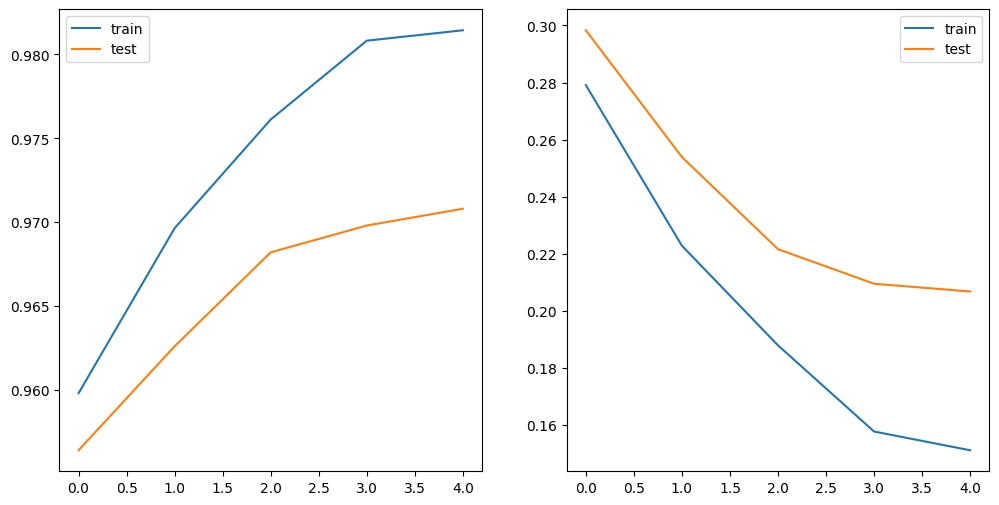

In [65]:
plot_results(results7)

In [66]:
NET8 = Network(100, loss=CrossEntropyLoss, init='normalized')
results8 = NET8.SGD_early_stopping(train_data,
                    no_epoch=5e-1, #set the threshold as 1/2
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9702


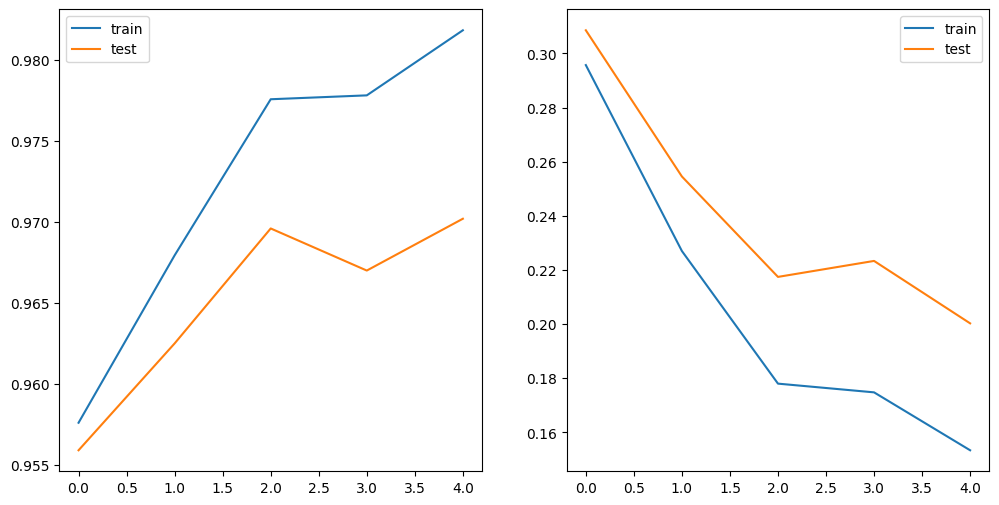

In [67]:
plot_results(results8)

######**When the threshold is increased, the accuracy decreases slightly using the same data, even though the accuracy is very high.**

####***Using expanded data set***

In [70]:
NET9 = Network(100, loss=CrossEntropyLoss, init='normalized')
results9 = NET9.SGD_early_stopping(expanded_train_data,
                    no_epoch=1e-1,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9775


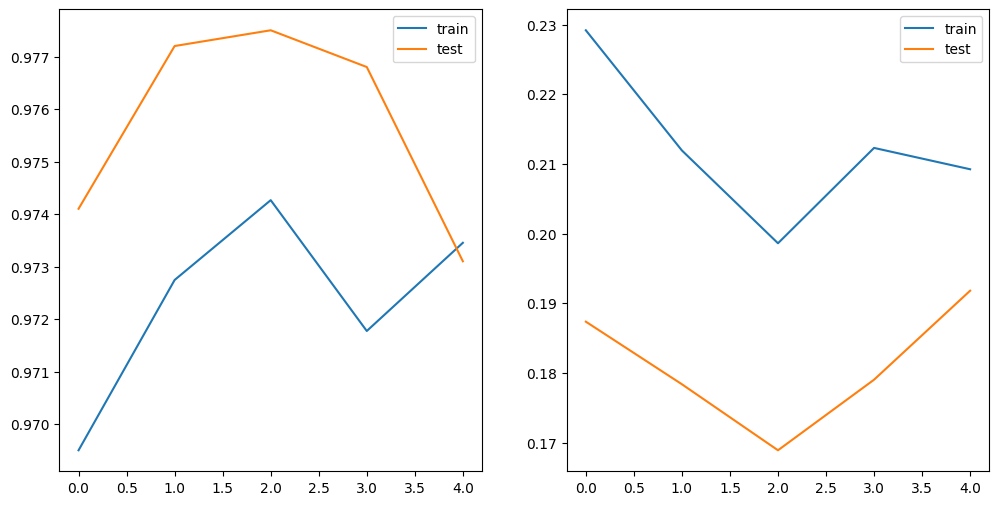

In [71]:
plot_results(results9)

#####**When the expanded data is used, the accuracy increases significantly.**

### **Variable Learning rate**

In [43]:
NET10 = Network(100, loss=CrossEntropyLoss, init='normalized')
results10 = NET10.SGD_var_learning_rate(train_data,
                    no_epoch=1e-1,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9782


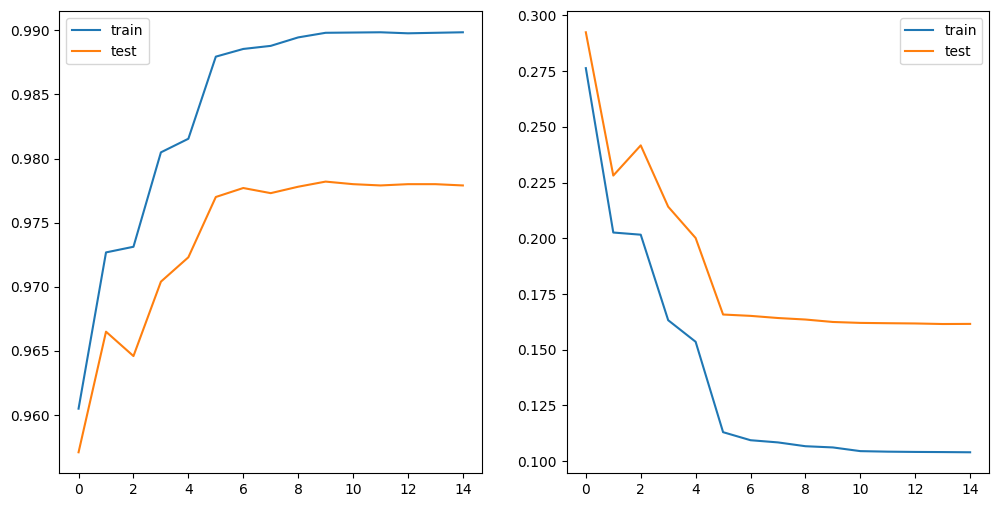

In [45]:
plot_results(results10)

In [49]:
NET11 = Network(100, loss=CrossEntropyLoss, init='normalized')
results11 = NET11.SGD_var_learning_rate(train_data,
                    no_epoch=5e-1,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9776


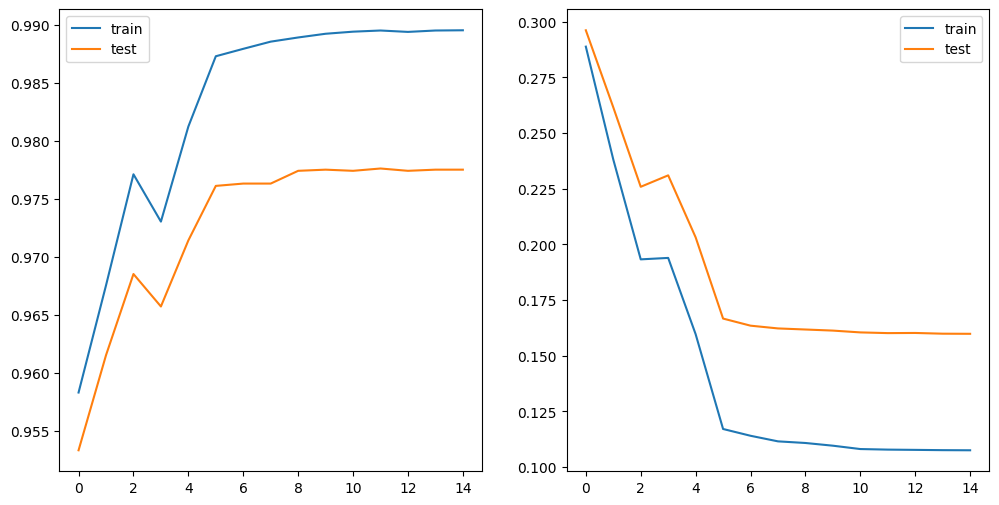

In [50]:
plot_results(results11)

#####**In this case, the accuracy also decreases as the threshold increaes.**

...

...

...

## **PROBLEM 5**

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0


Documentation for keras is located at https://keras.io

#### ***Loading the fashion data***

In [4]:
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape((60000, 28*28))
test_images = test_images.reshape((10000, 28*28))

In [7]:
train_images.shape

(60000, 784)

In [6]:
def plot_digit(x):
    x = np.reshape(x, (28, 28))
    plt.imshow(1.0-x, cmap='gray', vmin=0, vmax=1)

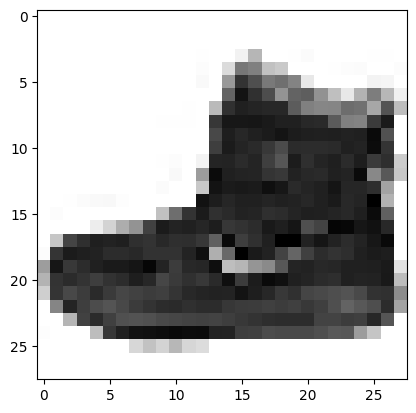

In [7]:
plot_digit(train_images[0])

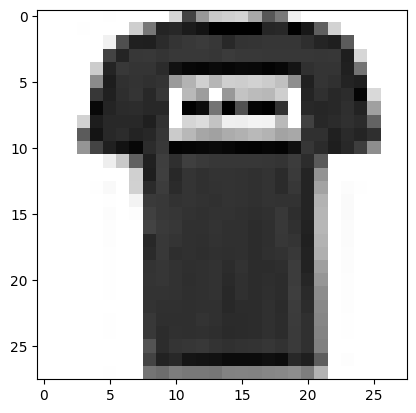

In [21]:
plot_digit(train_images[1])

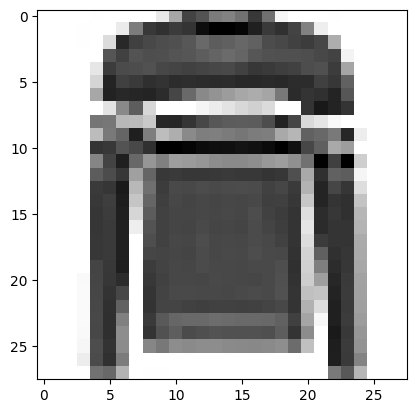

In [22]:
plot_digit(train_images[5])

### ***Model 1: Fully connected, 30 hidden neurons***

First define the layers.

In [8]:
model_fc_30 = tf.keras.Sequential([
#    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(30, activation=tf.keras.activations.sigmoid),
    tf.keras.layers.Dense(10)
])

Then "compile" the model, choosing loss and optimization algorithm.

Default activation is identity, so `Dense(10)` is a linear layer without applying any activation.

In [9]:
model_fc_30.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

`adam` is one of the most popular optimizers. It is SGD with some modifications.

`from_logits=False` means that the inputs to the loss are log-likelihoods. Then, the loss is what the book called softmax + log-likelihood loss.

If the dense layer already applied softmax, so the inputs are probabilities, then you should call `from_logits=True`.

The last part is to run SGD for a number of epochs:

In [10]:
model_fc_30.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6840 - accuracy: 0.7889
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4289 - accuracy: 0.8495
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3873 - accuracy: 0.8625
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3650 - accuracy: 0.8686
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3483 - accuracy: 0.8739
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3369 - accuracy: 0.8793
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3264 - accuracy: 0.8825
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3178 - accuracy: 0.8852
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3103 - accuracy: 0.8885
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.303

Evaluate accuracy on the test data

In [11]:
test_loss, test_acc = model_fc_30.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.3668 - accuracy: 0.8693 - 569ms/epoch - 2ms/step


We can keep training the same model from the last place

In [12]:
model_fc_30.fit(train_images, train_labels, epochs=20)
test_loss, test_acc = model_fc_30.evaluate(test_images,  test_labels, verbose=2)

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2982 - accuracy: 0.8913
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2926 - accuracy: 0.8936
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2875 - accuracy: 0.8960
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2837 - accuracy: 0.8976
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2797 - accuracy: 0.8997
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2745 - accuracy: 0.9007
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2719 - accuracy: 0.9018
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2680 - accuracy: 0.9029
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2638 - accuracy: 0.9029
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.261

### ***Model 2: Fully connected, 100 hidden neurons***

In [13]:
model_fc_100 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation=tf.keras.activations.sigmoid),
    tf.keras.layers.Dense(10)
])
model_fc_100.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_fc_100.fit(train_images, train_labels, epochs=30)

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5589 - accuracy: 0.8102
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3961 - accuracy: 0.8568
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3598 - accuracy: 0.8702
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3352 - accuracy: 0.8783
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3178 - accuracy: 0.8842
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3024 - accuracy: 0.8883
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2895 - accuracy: 0.8942
Epoch 8/30
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2771 - accuracy: 0.8995
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2671 - accuracy: 0.9025
Epoch 10/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.258

In [14]:
model_fc_100.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.3498 - accuracy: 0.8860 - 619ms/epoch - 2ms/step


[0.34980034828186035, 0.8859999775886536]

### ***Adjust the data for convolution***

In [10]:
train_images_conv = train_images.reshape((60000, 28, 28, 1))
test_images_conv = test_images.reshape((10000, 28, 28, 1))

### ***Model 3: 20 filters, 2x2 max pooling, 100 hidden neurons, ReLU***

In [11]:
model_cnn_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=20, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10)
])
model_cnn_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_cnn_1.fit(train_images_conv, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 37s 19ms/step - loss: 0.4308 - accuracy: 0.8488
Epoch 2/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.2953 - accuracy: 0.8939
Epoch 3/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.2524 - accuracy: 0.9077
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2204 - accuracy: 0.9184
Epoch 5/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1949 - accuracy: 0.9276
Epoch 6/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1699 - accuracy: 0.9373
Epoch 7/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1540 - accuracy: 0.9424
Epoch 8/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1339 - accuracy: 0.9503
Epoch 9/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1191 - accuracy: 0.9554
Epoch 10/10
1875/1875 [==============================] - 33s 17m

In [12]:
model_cnn_1.evaluate(test_images_conv,  test_labels, verbose=2)

313/313 - 2s - loss: 0.3054 - accuracy: 0.9082 - 2s/epoch - 5ms/step


[0.30544570088386536, 0.9082000255584717]

In [13]:
model_cnn_1.fit(train_images_conv, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0950 - accuracy: 0.9646
Epoch 2/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0833 - accuracy: 0.9689
Epoch 3/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0736 - accuracy: 0.9724
Epoch 4/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0655 - accuracy: 0.9765
Epoch 5/5
1875/1875 [==============================] - 40s 22ms/step - loss: 0.0591 - accuracy: 0.9787


In [15]:
model_cnn_1.evaluate(test_images_conv,  test_labels, verbose=2)

313/313 - 4s - loss: 0.3781 - accuracy: 0.9143 - 4s/epoch - 12ms/step


[0.37812572717666626, 0.9143000245094299]

In [16]:
model_cnn_1.fit(train_images_conv, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0540 - accuracy: 0.9808
Epoch 2/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0487 - accuracy: 0.9823
Epoch 3/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0444 - accuracy: 0.9836
Epoch 4/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0407 - accuracy: 0.9848
Epoch 5/5
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0349 - accuracy: 0.9874


In [17]:
model_cnn_1.evaluate(test_images_conv,  test_labels, verbose=2)

313/313 - 2s - loss: 0.4917 - accuracy: 0.9108 - 2s/epoch - 6ms/step


[0.4917197823524475, 0.9107999801635742]

### ***Model 3: 20 and 40 filters, 2x2 max pooling, 100 hidden neurons, ReLU***

Please implement the second CNN model as given on the lecture slides.

In [18]:
model_cnn_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=20, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=40, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10)
])

model_cnn_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_cnn_1.fit(train_images_conv, train_labels, epochs=10)



Epoch 1/10
1875/1875 [==============================] - 48s 25ms/step - loss: 0.5001 - accuracy: 0.8196
Epoch 2/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.3264 - accuracy: 0.8824
Epoch 3/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2820 - accuracy: 0.8968
Epoch 4/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2529 - accuracy: 0.9076
Epoch 5/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.2292 - accuracy: 0.9164
Epoch 6/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.2106 - accuracy: 0.9211
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1951 - accuracy: 0.9269
Epoch 8/10
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1784 - accuracy: 0.9330
Epoch 9/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.1679 - accuracy: 0.9370
Epoch 10/10
1875/1875 [==============================] - 59s 31m

In [19]:
model_cnn_1.evaluate(test_images_conv,  test_labels, verbose=2)

313/313 - 3s - loss: 0.2862 - accuracy: 0.8993 - 3s/epoch - 8ms/step


[0.28615015745162964, 0.8992999792098999]

In [ ]:
model_cnn_1.fit(train_images_conv, train_labels, epochs=5)

### ***Model 4: 30 and 50 filters, 3×3 max pooling, 100 hidden neurons, ReLU***

In [20]:
model_cnn_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10)
])

model_cnn_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_cnn_1.fit(train_images_conv, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 41s 21ms/step - loss: 0.5819 - accuracy: 0.7865
Epoch 2/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3857 - accuracy: 0.8606
Epoch 3/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3309 - accuracy: 0.8794
Epoch 4/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.2996 - accuracy: 0.8917
Epoch 5/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.2801 - accuracy: 0.8967
Epoch 6/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2613 - accuracy: 0.9040
Epoch 7/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2473 - accuracy: 0.9081
Epoch 8/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.2335 - accuracy: 0.9139
Epoch 9/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.2220 - accuracy: 0.9180
Epoch 10/10
1875/1875 [==============================] - 37s 20m

In [47]:
model_cnn_1.evaluate(test_images_conv,  test_labels, verbose=2)

313/313 - 2s - loss: 0.2827 - accuracy: 0.8994 - 2s/epoch - 6ms/step


[0.282650887966156, 0.899399995803833]

In [48]:
model_cnn_1.fit(train_images_conv, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2021 - accuracy: 0.9242
Epoch 2/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1934 - accuracy: 0.9283
Epoch 3/5
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1846 - accuracy: 0.9303
Epoch 4/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1783 - accuracy: 0.9329
Epoch 5/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1709 - accuracy: 0.9352


#####***As the number of filters increases,  the training accuracy increases but  the test accuracy does not. The increase in the dimension of the max pooling does not cause any significant change or increase too.***